### Importing libraries

### Reading Resampled train stances 

In [117]:
import sys
import numpy as np
import nltk
import os
import re
_wnl = nltk.WordNetLemmatizer()
from tqdm import tqdm
import scipy
from csv import DictReader
import pandas as pd
nltk.download('punkt')
nltk.download('wordnet')
# sklearn dependencies
from sklearn import feature_extraction
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from collections import defaultdict
import collections
import matplotlib.pyplot as plt

# Function for reading the dataset
class DataSet():
    def __init__(self, name="train", path="/content/drive/My Drive/fnc-1"):
        self.path = path

        print("Reading dataset")
        bodies = name+"_bodies.csv"
        if name== 'train':
          stances = name+"_stances_resampled.csv"  
        else:
          stances = name+"_stances.csv"
          
        self.stances = self.read(stances)
       
        articles = self.read(bodies)
       
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])
        
        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))

    

    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Solving the problem of imbalanced data

In [118]:
train_stances=pd.read_csv('/content/drive/My Drive/fnc-1/train_stances.csv')
train_stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [119]:
print(train_stances.shape)

(49972, 3)


In [120]:
print("Train Data Distribution: ",collections.Counter(train_stances['Stance']))

Train Data Distribution:  Counter({'unrelated': 36545, 'discuss': 8909, 'agree': 3678, 'disagree': 840})


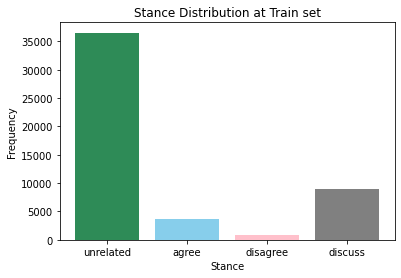

In [121]:
plt.bar(collections.Counter(train_stances['Stance']).keys(),collections.Counter(train_stances['Stance']).values(),color=[
                     'seagreen', 'skyblue','pink','gray'])
plt.xlabel("Stance")
plt.ylabel('Frequency')
plt.title('Stance Distribution at Train set')
plt.show()

In [122]:
train_stances_unrelated=train_stances[train_stances['Stance']=='unrelated']
train_stances_agree=train_stances[train_stances['Stance']=='agree']
train_stances_disagree=train_stances[train_stances['Stance']=='disagree']
train_stances_discuss=train_stances[train_stances['Stance']=='discuss']

In [123]:
print(train_stances_unrelated.shape)
print(train_stances_agree.shape)
print(train_stances_disagree.shape)
print(train_stances_discuss.shape)

(36545, 3)
(3678, 3)
(840, 3)
(8909, 3)


- Total stances: 49972
  - unrelated: 73.1%
  - agree: 7.3%
  - disagree:1.6%
  - discuss:17.8%

### Taking 50% of unrelated only | undersampling the abundant class 
##### https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html

In [124]:
train_stances_unrelated=train_stances_unrelated.sample(frac=1).reset_index(drop=True)[0:18272]

In [125]:
train_stances_unrelated

,Headline,Body ID,Stance
0,"Managua explosion not a meteorite, NASA suggests",1795,unrelated
1,Say 'eh-oh!' to the Teletubbies SUN BABY - can...,470,unrelated
2,Senior Western Intelligence Official Confirms ...,1252,unrelated
3,Christian Bale Is Steve Jobs,1839,unrelated
4,This Man Paid Off His Parents' Mortgage for Ch...,1459,unrelated
...,...,...,...
18267,Everyone chill! Banksy has NOT been arrested,1269,unrelated
18268,MPs credit sergeant-at-arms for saving lives i...,2410,unrelated
18269,Jordan king cites Clint Eastwood in revenge vow,803,unrelated
18270,#Hairgate: iPhone 6 users say device pulls out...,304,unrelated


In [126]:
train_stances_resampled=pd.concat([train_stances_unrelated,train_stances_agree
                                   ,train_stances_disagree,train_stances_discuss],axis=0)

In [127]:
train_stances_resampled=train_stances_resampled.sample(frac=1).reset_index(drop=True)

In [128]:
train_stances_resampled

,Headline,Body ID,Stance
0,Developer quits using the app he was hired to ...,2458,discuss
1,"Meteorite Strikes Nicaraguan Capital, Creates ...",1073,discuss
2,"Dead for 48 minutes, Catholic Priest claims Go...",2240,agree
3,"Spider burrowed into appendix scar, crawled th...",1848,unrelated
4,The Internet Tried To Make Axl Rose Its Latest...,144,unrelated
...,...,...,...
31694,Eyewitness: Viral Video That Netted $130K in D...,1429,discuss
31695,Banksy arrest hoax: US website claims street a...,1437,unrelated
31696,US drones hunt Isis leader in Syria,304,unrelated
31697,Soldier shot at war memorial in Canada,892,unrelated


In [129]:
train_stances_resampled.to_csv('/content/drive/My Drive/fnc-1/train_stances_resampled.csv',index=False)

### Functions to form various features 

In [130]:
# Feature Functions(taken from baseline and added cosine similarity)
def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
  # if not os.path.isfile(feature_file):
    feats = feat_fn(headlines, bodies)
    np.save(feature_file, feats)
    return np.load(feature_file)

def word_overlap_features(headlines, bodies):
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        clean_headline = get_tokenized_lemmas(clean_headline)
        clean_body = get_tokenized_lemmas(clean_body)
        features = [
            len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))]
        X.append(features)
    return X


def refuting_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        # 'refute',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_headline = get_tokenized_lemmas(clean_headline)
        features = [1 if word in clean_headline else 0 for word in _refuting_words]
        X.append(features)
    return X


def polarity_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]

    def calculate_polarity(text):
        tokens = get_tokenized_lemmas(text)
        return sum([t in _refuting_words for t in tokens]) % 2
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        features = []
        features.append(calculate_polarity(clean_headline))
        features.append(calculate_polarity(clean_body))
        X.append(features)
    return np.array(X)


def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features

def cosine_similarity_h(headlines, bodies):
	vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')#, max_features=1024)

	cos_sim_features = []
	for i in range(0, len(bodies)):
		body_headline = []
		body_headline.append(bodies[i])
		body_headline.append(headlines[i])
		tfidf = vectorizer.fit_transform(body_headline)

		cosine_similarity = (tfidf * tfidf.T).A
		cos_sim_features.append(cosine_similarity[0][1])

	
	cos_sim_array = np.array(cos_sim_features) 

	return cos_sim_array

def hand_features(headlines, bodies):

    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        X.append(binary_co_occurence(headline, body)
                 + binary_co_occurence_stops(headline, body)
                 + count_grams(headline, body))


    return X


### Functions to generate splits

In [131]:

# Functions to generate splits

def generate_hold_out_split (dataset, training = 0.8, base_dir="/content/drive/My Drive/fnc-1/"):
    r = random.Random()
    r.seed(1489215)

    article_ids = list(dataset.articles.keys())  # get a list of article ids
    r.shuffle(article_ids)  # and shuffle that list


    training_ids = article_ids[:int(training * len(article_ids))]
    hold_out_ids = article_ids[int(training * len(article_ids)):]

    # write the split body ids out to files for future use
    with open(base_dir+ "/"+ "training_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in training_ids]))

    with open(base_dir+ "/"+ "hold_out_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in hold_out_ids]))



def read_ids(file,base):
    ids = []
    with open(base+"/"+file,"r") as f:
        for line in f:
           ids.append(int(line))
        return ids


def kfold_split(dataset, training = 0.8, n_folds = 10, base_dir="/content/drive/My Drive/fnc-1"):
    if not (os.path.exists(base_dir+ "/"+ "training_ids.txt")
            and os.path.exists(base_dir+ "/"+ "hold_out_ids.txt")):
        generate_hold_out_split(dataset,training,base_dir)

    training_ids = read_ids("training_ids.txt", base_dir)
    hold_out_ids = read_ids("hold_out_ids.txt", base_dir)

    folds = []
    for k in range(n_folds):
        folds.append(training_ids[int(k*len(training_ids)/n_folds):int((k+1)*len(training_ids)/n_folds)])

    return folds,hold_out_ids


def get_stances_for_folds(dataset,folds,hold_out):
    stances_folds = defaultdict(list)
    stances_hold_out = []
    for stance in dataset.stances:
        if stance['Body ID'] in hold_out:
            stances_hold_out.append(stance)
        else:
            fold_id = 0
            for fold in folds:
                if stance['Body ID'] in fold:
                    stances_folds[fold_id].append(stance)
                fold_id += 1

    return stances_folds,stances_hold_out


### Functions to generate the score

In [132]:
# Score functions
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm

# function for printing confusion Matrix
def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score




### Generating Features

In [133]:


def generate_features(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    X_overlap = gen_or_load_feats(word_overlap_features, h, b, "overlap."+name+".npy")
    X_refuting = gen_or_load_feats(refuting_features, h, b, "refuting."+name+".npy")
    X_polarity = gen_or_load_feats(polarity_features, h, b, "polarity."+name+".npy")
    X_hand = gen_or_load_feats(hand_features, h, b, "hand."+name+".npy")
    X_cosine=gen_or_load_feats(cosine_similarity_h,h,b,"cosine."+name+".npy")

    X = np.c_[X_hand, X_polarity, X_refuting, X_overlap,X_cosine]
    X = preprocessing.scale(X)
    return X,y
    



    
#Load the training dataset and generate folds
d = DataSet()
folds,hold_out = kfold_split(d,n_folds=10)
fold_stances, hold_out_stances = get_stances_for_folds(d,folds,hold_out)

# Load the competition dataset
competition_dataset = DataSet("competition_test")
X_competition, y_competition = generate_features(competition_dataset.stances, competition_dataset, "competition")
    
  
Xs = dict()
ys = dict()

# Load/Precompute all features now
X_holdout,y_holdout = generate_features(hold_out_stances,d,"holdout")
for fold in fold_stances:
    Xs[fold],ys[fold] = generate_features(fold_stances[fold],d,str(fold))


best_score = 0
best_fold = None

    





    
# print(predicted)




Reading dataset
Total stances: 31699
Total bodies: 1683


0it [00:00, ?it/s]

Reading dataset
Total stances: 25413
Total bodies: 904


25413it [01:28, 287.29it/s]
25413it [00:05, 4888.25it/s]
25413it [01:29, 282.58it/s]
25413it [01:34, 268.84it/s]
6143it [00:22, 273.35it/s]
6143it [00:01, 4867.26it/s]
6143it [00:22, 267.55it/s]
6143it [00:24, 248.77it/s]
2528it [00:09, 273.12it/s]
2528it [00:00, 5009.29it/s]
2528it [00:09, 266.10it/s]
2528it [00:09, 254.88it/s]
2847it [00:10, 271.88it/s]
2847it [00:00, 5141.40it/s]
2847it [00:10, 261.60it/s]
2847it [00:11, 250.97it/s]
2959it [00:11, 266.81it/s]
2959it [00:00, 4875.83it/s]
2959it [00:11, 261.51it/s]
2959it [00:11, 246.65it/s]
2395it [00:09, 265.98it/s]
2395it [00:00, 4997.53it/s]
2395it [00:09, 259.93it/s]
2395it [00:09, 246.33it/s]
2498it [00:08, 281.75it/s]
2498it [00:00, 5014.32it/s]
2498it [00:08, 288.82it/s]
2498it [00:09, 266.00it/s]
2603it [00:09, 284.38it/s]
2603it [00:00, 5102.10it/s]
2603it [00:09, 280.17it/s]
2603it [00:09, 266.45it/s]
2499it [00:09, 257.39it/s]
2499it [00:00, 5176.26it/s]
2499it [00:09, 251.62it/s]
2499it [00:10, 239.72it/s]
2530it [00:09, 

In [134]:
# Classifier for each fold
for fold in fold_stances:
    ids = list(range(len(folds)))
    del ids[fold]

    X_train = np.vstack(tuple([Xs[i] for i in ids]))
    y_train = np.hstack(tuple([ys[i] for i in ids]))

    X_test = Xs[fold]
    y_test = ys[fold]
            
            
    gradientboosting = GradientBoostingClassifier( n_estimators=100, random_state=42,verbose=True,subsample=0.9)
    gradientboosting.fit(X_train, y_train)
            
              
    predicted = [LABELS[int(a)] for a in gradientboosting.predict(X_test)]   
          
            
    actual = [LABELS[int(a)] for a in y_test]

    fold_score, _ = score_submission(actual, predicted)
    max_fold_score, _ = score_submission(actual, actual)

    score = fold_score/max_fold_score

    print("Score for fold "+ str(fold) + " was - " + str(score))
    if score > best_score:
        best_score = score
        best_fold = gradientboosting



#Run on Holdout set and report the final score on the holdout set
predicted = [LABELS[int(a)] for a in best_fold.predict(X_holdout)]
    
    
actual = [LABELS[int(a)] for a in y_holdout]

    
report_score(actual,predicted)
print("")
print("")
#Run on competition dataset
   
predicted = [LABELS[int(a)] for a in best_fold.predict(X_competition)]
actual = [LABELS[int(a)] for a in y_competition]
    
    
a=report_score(actual,predicted)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       18685.0352         264.6474           32.22s
         2       16929.2196         197.1368           31.59s
         3       15569.1233         147.4879           31.70s
         4       14478.9138         118.4680           31.18s
         5       13562.1310          98.3605           30.57s
         6       12778.9238          81.1998           30.26s
         7       12209.8036          64.6610           29.97s
         8       11703.1468          54.7491           29.80s
         9       11288.3237          46.3221           29.61s
        10       10923.6287          38.9961           29.43s
        20        9122.5592           7.5908           25.94s
        30        8575.7122           2.8342           22.59s
        40        8253.7819           0.3899           19.28s
        50        8125.1535          -0.0561           15.99s
        60        8012.6254          -0.0954           12.76s
       

In [135]:

data = {'Iterations':  [1, 2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100],
        'Loss': [22194.4070,19779.9174,17959.4557,16603.5056,15511.8594, 14602.8131,13910.4883,13208.1117,12633.8252,12271.9072,10183.7280,9568.5745,9206.9733,9001.6804,8825.1934,
                8716.2480, 8578.4964,8487.2534,8403.3948],
        
        }
df_bert = pd.DataFrame (data, columns = ['Iterations','Loss'])

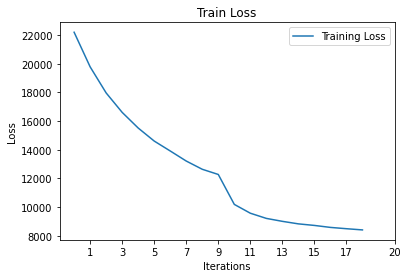

In [136]:
# Plotting train loss vs Iterations
import matplotlib.pyplot as plt

plt.plot(df_bert['Loss'])
plt.xlabel('Iterations')
plt.xticks([1,3,5,7,9,11,13,15,17,20])
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend(['Training Loss'])
plt.savefig('Gradient_loss.png')
plt.show()

In [137]:
comp_test=pd.read_csv('/content/drive/My Drive/fnc-1/competition_test_stances.csv')

In [138]:
#General Loss
from sklearn.metrics import accuracy_score
accuracy_score(comp_test['Stance'],predicted)

0.8480698854916775

In [139]:
#Generating answers.csv
body_id = []
headlines = []
stances = np.copy(np.array(predicted))

for i in range(len(competition_dataset.stances)):
    body_id.append(competition_dataset.stances[i]['Body ID'])
    headlines.append(competition_dataset.stances[i]['Headline'])
test_data = pd.DataFrame(columns=['Headline', 'Body ID', 'Stance'])
test_data['Headline'] = headlines
test_data['Body ID'] = body_id
test_data['Stance'] = stances
print(test_data.head())

test_data.to_csv('gradientboost_100.csv', index=False, encoding='utf-8')


                                            Headline  Body ID     Stance
0  Ferguson riots: Pregnant woman loses eye after...     2008  unrelated
1  Crazy Conservatives Are Sure a Gitmo Detainee ...     1550  unrelated
2  A Russian Guy Says His Justin Bieber Ringtone ...        2  unrelated
3  Zombie Cat: Buried Kitty Believed Dead, Meows ...     1793  unrelated
4  Argentina's President Adopts Boy to End Werewo...       37  unrelated


In [140]:
#Calculating f1 score of individual stances type(Competition set)
from sklearn.metrics import f1_score

def calculate_f1scores(y_true, y_predicted):
    
    f1_macro = f1_score(y_true, y_predicted, average='macro')
    f1_classwise = f1_score(y_true, y_predicted, average=None, labels=["agree", "disagree", "discuss", "unrelated"])

    result = "F1 macro: {:.3f}".format(f1_macro * 100) + "% \n"
    result += "F1 agree: {:.3f}".format(f1_classwise[0] * 100) + "% \n"
    result += "F1 disagree: {:.3f}".format(f1_classwise[1] * 100) + "% \n"
    result += "F1 discuss: {:.3f}".format(f1_classwise[2] * 100) + "% \n"
    result += "F1 unrelated: {:.3f}".format(f1_classwise[3] * 100) + "% \n"
    return result
print(calculate_f1scores(predicted,actual))

F1 macro: 46.823% 
F1 agree: 20.218% 
F1 disagree: 1.642% 
F1 discuss: 69.224% 
F1 unrelated: 96.207% 



In [141]:
# calculating precision,recall,f1-score,support for Competition set
from sklearn.metrics import classification_report

eval_report = classification_report(predicted,actual)
print('Test report', eval_report)

Test report               precision    recall  f1-score   support

       agree       0.14      0.35      0.20       758
    disagree       0.01      0.18      0.02        34
     discuss       0.89      0.57      0.69      6954
   unrelated       0.94      0.98      0.96     17667

    accuracy                           0.85     25413
   macro avg       0.49      0.52      0.47     25413
weighted avg       0.90      0.85      0.86     25413

